In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
file_path = 'ratings_Electronics.csv'
data = pd.read_csv(file_path, names=['userId', 'productId', 'rating', 'timestamp'])

# Check for missing values
print("Missing Values:", data.isnull().sum())

# Encode userId and productId
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['user'] = user_encoder.fit_transform(data['userId'])
data['product'] = product_encoder.fit_transform(data['productId'])

# Save mappings for decoding
user_mapping = dict(zip(data['user'], data['userId']))
product_mapping = dict(zip(data['product'], data['productId']))

# Train-Test Split
X = data[['user', 'product']].values
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Missing Values: userId       0
productId    0
rating       0
timestamp    0
dtype: int64


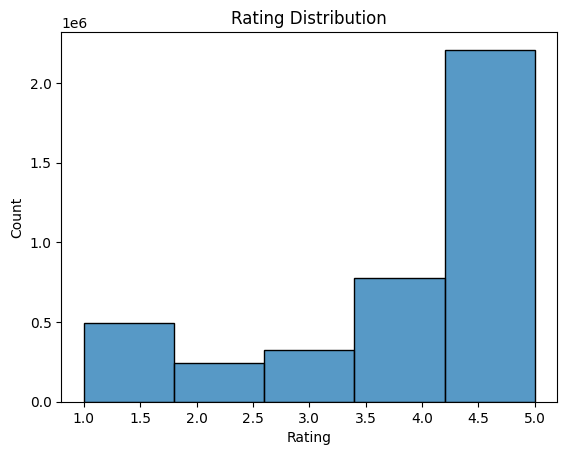

<ipython-input-12-c043613d16bf>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_active_users.index, y=most_active_users.values, palette='viridis')


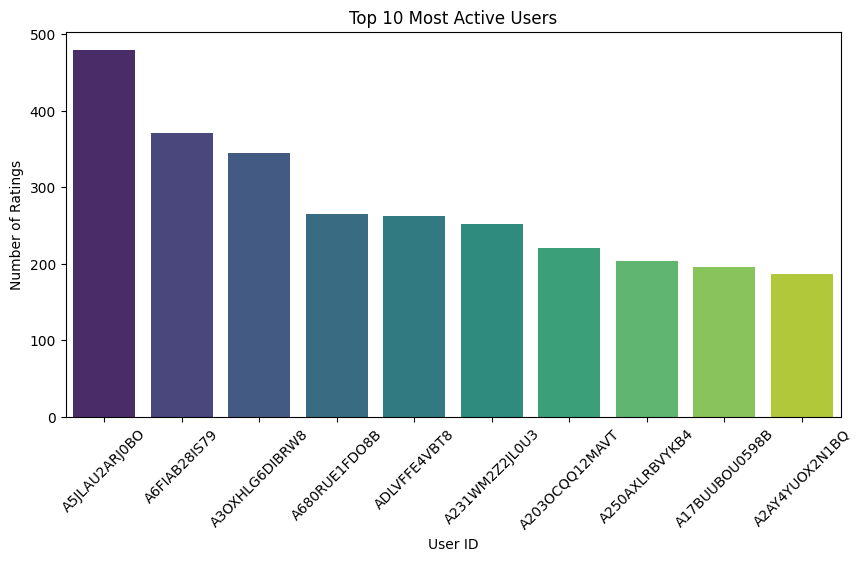

<ipython-input-12-c043613d16bf>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_rated_products.index, y=most_rated_products.values, palette='viridis')


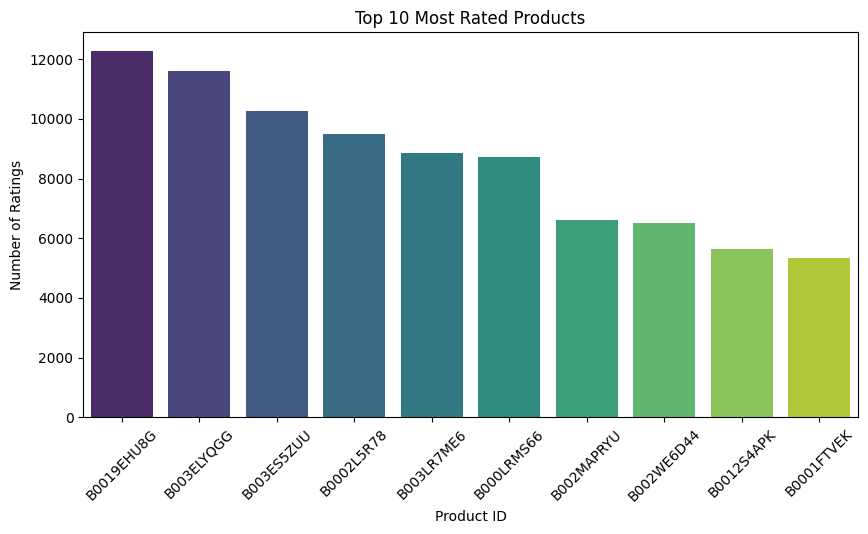

In [12]:
# Distribution of Ratings
sns.histplot(data['rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top 10 Most Active Users
most_active_users = data['userId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=most_active_users.index, y=most_active_users.values, palette='viridis')
plt.title('Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

# Top 10 Most Rated Products
most_rated_products = data['productId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=most_rated_products.index, y=most_rated_products.values, palette='viridis')
plt.title('Top 10 Most Rated Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


In [2]:
n_users = data['user'].nunique()
n_products = data['product'].nunique()


In [3]:
n_products

476002

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# Define the model
n_users = data['user'].nunique()
n_products = data['product'].nunique()

# Input layers
user_input = Input(shape=(1,))
product_input = Input(shape=(1,))

# Embedding layers
user_embedding = Embedding(input_dim=n_users, output_dim=8, input_length=1)(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=8, input_length=1)(product_input)

# Flatten embeddings
user_flatten = Flatten()(user_embedding)
product_flatten = Flatten()(product_embedding)

# Concatenate embeddings
concat = Concatenate()([user_flatten, product_flatten])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1)(dense2)

# Compile model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80829/80829 ━━━━━━━━━━━━━━━━━━━━ 522s 6ms/step - loss: 1.9120 - val_loss: 1.7226
Epoch 2/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 576s 7ms/step - loss: 0.9357 - val_loss: 2.1904
Epoch 3/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 561s 7ms/step - loss: 0.6692 - val_loss: 2.1022
Epoch 4/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 562s 7ms/step - loss: 0.5339 - val_loss: 2.1401
Epoch 5/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 545s 6ms/step - loss: 0.4556 - val_loss: 2.1990
Epoch 6/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 578s 7ms/step - loss: 0.4003 - val_loss: 2.2250
Epoch 7/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 548s 6ms/step - loss: 0.3581 - val_loss: 2.2193
Epoch 8/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 562s 6ms/step - loss: 0.3262 - val_loss: 2.3004
Epoch 9/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 578s 7ms/step - loss: 0.2994 - val_loss: 2.3761
Epoch 10/10
80829/80829 ━━━━━━━━━━━━━━━━━━━━ 562s 7ms/step - loss: 0.2737 - val_loss: 2.3578


In [14]:
# Predict and recommend
def recommend_products(user_original_id, input_product_id, top_n=5):
    # Encode original userId and productId
    user_idx = user_encoder.transform([user_original_id])[0]
    product_idx = product_encoder.transform([input_product_id])[0]

    # Predict scores for all products
    all_products = np.arange(n_products)
    scores = model.predict([np.full(n_products, user_idx), all_products])

    # Exclude the input product
    scores[product_idx] = -np.inf

    # Get top N recommended products
    top_product_indices = np.argsort(-scores.flatten())[:top_n]
    recommended_product_ids = [product_mapping[idx] for idx in top_product_indices]

    return recommended_product_ids

# Example usage
user_to_recommend = 'AKM1MP6P0OYPR'
input_product_id = '0132793040'
recommended_products = recommend_products(user_to_recommend, input_product_id, top_n=5)
print(f"Recommended products for user {user_to_recommend} and product {input_product_id}: {recommended_products}")


6891/6891 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Recommended products for user AKM1MP6P0OYPR and product 0132793040: ['B0037ATHF4', 'B001S2RDCM', 'B0007RB280', 'B002WC8PK6', 'B001LYPITM']


In [15]:
# Predict and recommend with ratings
def recommend_products_with_ratings(user_original_id, input_product_id=None, top_n=5):
    # Encode the original userId
    user_idx = user_encoder.transform([user_original_id])[0]

    # Predict scores for all products
    all_products = np.arange(n_products)
    scores = model.predict([np.full(n_products, user_idx), all_products]).flatten()

    # Optionally exclude the input product
    if input_product_id:
        product_idx = product_encoder.transform([input_product_id])[0]
        scores[product_idx] = -np.inf  # Exclude the product by setting its score to -inf

    # Get top N recommended products
    top_product_indices = np.argsort(-scores)[:top_n]
    recommended_product_ids = [product_mapping[idx] for idx in top_product_indices]
    recommended_ratings = [scores[idx] for idx in top_product_indices]

    # Combine recommendations with predicted ratings
    recommendations_with_ratings = list(zip(recommended_product_ids, recommended_ratings))
    return recommendations_with_ratings

# Example usage
user_to_recommend = 'AKM1MP6P0OYPR'
input_product_id = '0132793040'
recommendations = recommend_products_with_ratings(user_to_recommend, input_product_id, top_n=5)

# Display results
print(f"Recommendations for user {user_to_recommend} based on product {input_product_id}:")
for product_id, rating in recommendations:
    print(f"Product: {product_id}, Predicted Rating: {rating:.2f}")


6891/6891 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Recommendations for user AKM1MP6P0OYPR based on product 0132793040:
Product: B0037ATHF4, Predicted Rating: 5.15
Product: B001S2RDCM, Predicted Rating: 5.14
Product: B0007RB280, Predicted Rating: 5.11
Product: B002WC8PK6, Predicted Rating: 5.09
Product: B001LYPITM, Predicted Rating: 5.08


In [ ]:

user_to_recommend = 'A1GI0U4ZRJA8WN'
input_product_id = '0439886341'
recommendations = recommend_products_with_ratings(user_to_recommend, input_product_id, top_n=5)

# Display results
print(f"Recommendations for user {user_to_recommend} based on product {input_product_id}:")
for product_id, rating in recommendations:
    print(f"Product: {product_id}, Predicted Rating: {rating:.2f}")

1844/6891 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step